In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

import string

%matplotlib inline

#sns.set_style("dark")

In [10]:
def get_hour(item):
    return item.hour

def get_day_frame(directory, date, remove_zeros=True, cutoff_area=10000, dropna_thres=4,
                  parse_filename=False, find_cumtime=True,
                  col_names = ['Interval', 'x', 'y', 'Area', 'Hour', 'Minute', 'Second']):
    """
    Returns the day frame for all files in the directory
    date: (month, date, year) tuple, for adding the relevant columns
    parse_filename: set True for files without timestamp, will infer timestamps from filename
    find_cumtime: set False for files that have intervals that are cumulative instead of dt
    """
    files = glob.glob(directory + '/*.csv') 
    frames = []
    for filename in files:
        obs = pd.read_csv(filename, header=None, names=col_names)
        
        # Remove nan columns
        obs.dropna(thresh=dropna_thres)
        
        # Parse filename to get time of the record
        if parse_filename:
            components = string.split(filename, '_')
            timestr = string.join(components[1:], ':')[:-4]
            endtime = pd.to_datetime(timestr)
            
            
            if find_cumtime:
                cum_time = np.cumsum(obs.Interval)
            else:
                cum_time = obs.Interval
            
            cum_time_delta = pd.to_timedelta(cum_time, unit='s')
            starttime = endtime - cum_time_delta[obs.shape[0] - 1]
            obs['Time'] = starttime + cum_time_delta
        
                 
        frames.append(obs)

    # Concatenate readings from all files
    day_frame = pd.concat(frames)
    day_frame['Day'] = date[1]
    day_frame['Month'] = date[0]
    day_frame['Year'] = date[2]
    
    if not parse_filename:
        day_frame['Time'] = pd.to_datetime(day_frame[['Day','Month', 'Year','Hour','Minute','Second']])
    
    # Light hour is from 9am to 7pm
    day_frame['Light'] = (day_frame.Time.apply(get_hour) >= 7) & (day_frame.Time.apply(get_hour) <= 21)
    
    # Remove zeros if specified
    if remove_zeros:
        day_frame = day_frame[(day_frame['x'] != 0) & (day_frame['y'] != 0)]
        
    # Remove entries which exceed a cutoff area
    if cutoff_area != None:
        day_frame = day_frame[day_frame.Area < cutoff_area]
        
    
    
    return day_frame
  

def collect_all_days(parent_dir, days, remove_zeros=True, cutoff_area=10000, dropna_thres=4,
                  parse_filename=False,
                  col_names = ['Interval', 'x', 'y', 'Area', 'Hour', 'Minute', 'Second']):
    '''
    ------------------------
    Inputs:
    parent_dir: string indicating parent directory
    days: list of recording days
    ------------------------
    Output:
    A pd frame for all observations of that animal
    ------------------------    
    '''
    frames = []
    for day in days:
        #datestr = str(day[0]) + '/' + str(day[1]) + '/' + str(day[2])
        #datetime = pd.to_datetime(datestr)
        directory = parent_dir + day.strftime('%m%d') + '/'
        print directory
        if os.path.isdir(directory):
            print day.month, day.day, day.year
            day_frame = get_day_frame(directory, (day.month, day.day, day.year),
                                     remove_zeros, cutoff_area, dropna_thres,
                                     parse_filename, col_names)
            frames.append(day_frame)
        else:
            print '     Directory does not exist'
    
    return pd.concat(frames)

In [11]:
days = pd.date_range('9/25/2016', periods=5, freq='d')
frame_2CW100_all = collect_all_days('2CW100/', days)

2CW100/0925/
9 25 2016
2CW100/0926/
9 26 2016
2CW100/0927/
9 27 2016
2CW100/0928/
9 28 2016
2CW100/0929/
9 29 2016


In [17]:
days = pd.date_range('7/7/2016', periods=5, freq='d')
frame_2CW305_all = collect_all_days('2CW305/', days)


In [43]:
days = pd.date_range('6/28/2016', periods=2, freq='d')
frame_2CW318_all = collect_all_days('2CW318/', days, cutoff_area=None, parse_filename=True)

2CW318/0628/
2CW318/0629/


In [66]:
fr = get_day_frame('2CW318/0628', (6,28,2016), cutoff_area=None, parse_filename=True, find_cumtime=False)

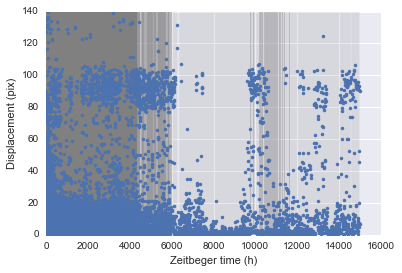

In [45]:
frame_2CW318_all['Displacement'] = get_displacement(frame_2CW318_all)
frame_2CW318_all['ZeitTime'] = get_zeit(frame_2CW318_all, start_time_str='6/28/2016 7:00AM')
plot_all_data(frame_2CW318_all)

In [34]:
frame_2CW318_all.shape

(0, 12)

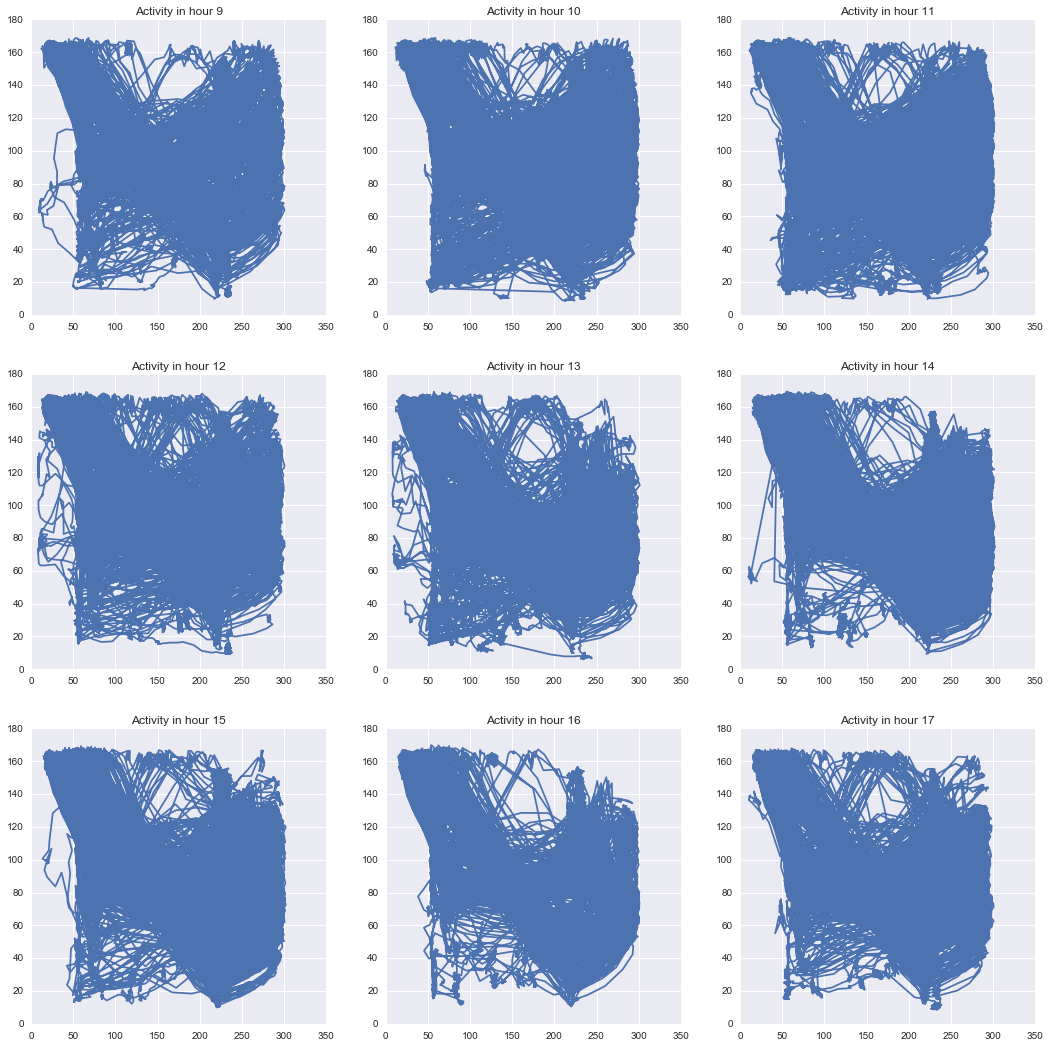

In [4]:
frame_to_display = day_frame_0925

# Visualization of hourly patterns
fig, ax = plt.subplots(3, 3, figsize=(18,18))
ax_pos = [(x,y) for x in range(3) for y in range(3)] # list all positions on the grid

hour = 9
for coord in ax_pos:
    hour_frame = frame_to_display[frame_to_display['Hour'] == hour]
    ax[coord].plot(hour_frame['x'], hour_frame['y'])
    ax[coord].set_title('Activity in hour ' + str(hour))
    
    hour += 1

In [5]:
def get_displacement(day_frame):
    '''
    Get displacement from x and y coords
    '''
    dx = np.diff(day_frame['x'])
    dy = np.diff(day_frame['y'])
    displacement = np.sqrt(dx * dx + dy * dy)
    
    # Diff returns n-1 values, so concatenate a 0 behind and make a new column
    return np.concatenate((displacement, [0])) 

def get_zeit(day_frame, start_time_str=None, use_time_field=False):
    '''
    Compute the zeitgeber time, starting from 9am, in unit of hours
    '''
    timeseries = day_frame.Time
    
    if start_time_str == None:
        starttime = timeseries[0]
    else:
        starttime = pd.to_datetime(start_time_str)

    return (timeseries - starttime) / pd.Timedelta(1, unit='h')

def plot_all_data(frame):
    '''
    Make a plot of all displacement values
    '''
    fig, ax = plt.subplots()
    ax.plot(frame['ZeitTime'], frame['Displacement'], '.')
    ax.fill_between(frame.ZeitTime, 0, ax.get_ylim()[1], 
                    where=~frame.Light, color='gray',  alpha=0.3)
    ax.set_xlabel('Zeitbeger time (h)')
    ax.set_ylabel('Displacement (pix)')
    
def ecdf(data):
    return np.sort(data), np.arange(len(data)) / float(len(data))

def aggregate_activity(day_frame, time, unit):
    """
    Unit: either 'Hour', 'Minute', or 'Second'
    Returns a data frame which is the total distance travelled in time * unit time specified
    """
    if unit == 'Hour':
        scale = 3600
    elif unit == 'Minute':
        scale = 60
    elif unit == 'Second':
        scale = 1
    else:
        raise ValueError('Invalid time unit')
        
    group_duration = time * scale # Number of seconds to group
    SECS_PER_DAY = 3600 * 24
    
    # ZeitTime is measured in hours, partitioned into groups of
    # specified group_duration
    group = (day_frame['ZeitTime'] / (group_duration/3600.0)).astype('int')
    agg_displacement = day_frame['Displacement'].groupby(group)
    
    agg_sum_grouped = agg_displacement.sum()
    
    # Create data frame with day information
    day = agg_sum_grouped.index / int(SECS_PER_DAY / group_duration)
    time_in_day = agg_sum_grouped.index % int(SECS_PER_DAY / group_duration)
    
    agg_frame_grouped = pd.DataFrame.from_items([('Period', time_in_day), 
                                                 ('Activity', agg_sum_grouped), ('Day', day)])
    
    
    
    return agg_frame_grouped

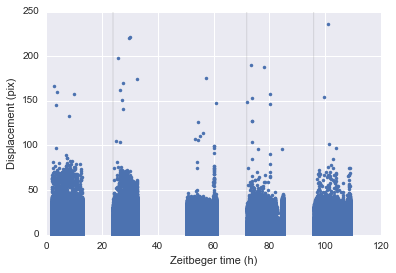

In [12]:
# Calculate displacement and zeitbeger time
frame_2CW100_all['Displacement'] = get_displacement(frame_2CW100_all)
frame_2CW100_all['ZeitTime'] = get_zeit(frame_2CW100_all, start_time_str='9/25/2016 7:00AM')
plot_all_data(frame_2CW100_all)

In [7]:
frame_2CW100_all

,Interval,x,y,Area,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
0,0.044798,223.09,117.430,1345,9,5,0.462,25,9,2016,2016-09-25 09:05:00.462,True,0.812527,2.083462
1,0.136530,223.88,117.620,1412,9,5,0.599,25,9,2016,2016-09-25 09:05:00.599,True,9.725482,2.083500
2,0.141080,229.03,125.870,1934,9,5,0.740,25,9,2016,2016-09-25 09:05:00.740,True,8.993386,2.083539
3,0.063108,224.40,118.160,1422,9,5,0.803,25,9,2016,2016-09-25 09:05:00.803,True,0.180278,2.083556
4,0.065758,224.34,117.990,1436,9,5,0.869,25,9,2016,2016-09-25 09:05:00.869,True,10.212938,2.083575
5,0.067577,229.54,126.780,1988,9,5,0.937,25,9,2016,2016-09-25 09:05:00.937,True,0.304138,2.083594
6,0.065412,229.24,126.830,2024,9,5,1.002,25,9,2016,2016-09-25 09:05:01.002,True,0.501199,2.083612
7,0.065407,228.80,127.070,2051,9,5,1.067,25,9,2016,2016-09-25 09:05:01.067,True,0.547449,2.083630
8,0.064656,228.71,126.530,2009,9,5,1.132,25,9,2016,2016-09-25 09:05:01.132,True,4.483715,2.083648
9,0.064802,226.12,130.190,2545,9,5,1.197,25,9,2016,2016-09-25 09:05:01.197,True,0.599333,2.083666


In [42]:
frame_2CW305_all['Displacement'] = get_displacement(frame_2CW305_all)
frame_2CW305_all['ZeitTime'] = get_zeit(frame_2CW305_all, start_time_str='7/7/2016 7:00AM')
plot_all_data(frame_2CW305_all)

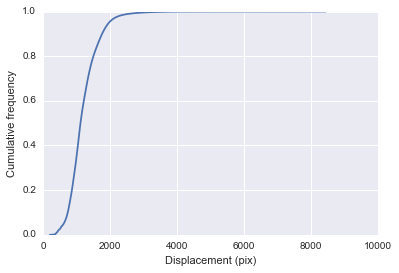

In [15]:
# Display the ecdf of all displacements
x, y = ecdf(frame_2CW100_all.Area)
plt.plot(x, y)
plt.xlim((0,10000))
plt.xlabel('Displacement (pix)')
plt.ylabel('Cumulative frequency')

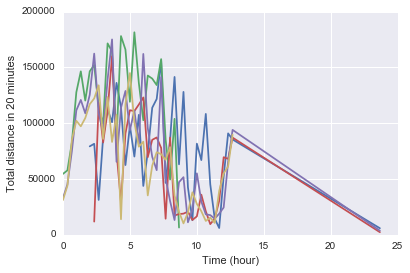

In [13]:
activity = aggregate_activity(frame_2CW100_all, time=20, unit='Minute')
for day in range(5):
    activity_day = activity.Activity[activity.Day == day]
    time_in_day = activity.Period[activity.Day == day] /3
    plt.plot(time_in_day, activity_day)
plt.xlabel('Time (hour)')
plt.ylabel('Total distance in 20 minutes')
